# torch.nn.Conv2d

```
torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

- 2D 컨볼루션(합성곱)을 여러 입력 평면(input planes)에 걸쳐 나타나는 입력 신호(input signal)에 적용한다.
- 입력 텐서 $(N, C_{in}, H, W)$와 출력 텐서 $(N, C_{out}, H_{out}, W_{out})$의 관계는 다음 도식으로 나타난다.

$$
\text{if } i = 0, 1, \cdots, N-1,\\
\text{and } j = 0, 1, \cdots , C_{out}-1,\\
\text{and } k = 0, 1, \cdots , C_{in}-1,\\[1.5em]
\text{then}\\[1.5em]
out = 
\underset{(N \times C_{out} \times H_{out} \times W_{out})}{\begin{pmatrix}
out_{0,0} & \cdots & out_{0, C_{out}-1}\\
\vdots & \ddots   &\vdots\\
out_{N-1, 0} & \cdots & out_{N-1, C_{out}-1}
\end{pmatrix}} \\[1.5em]
\text{and }\\[1.5em]
out_{i, j} = \text{bias}(j) + \sum^{C_{in} - 1}_{k = 0}{\text{weight}(j, k) \star \text{input}(i, k)}

$$

- $\star$는 상호상관함수(크로스 코릴레이션), $N$은 배치 사이즈, $C$는 채널의 수, $H$는 높이, $W$는 너비다.
  - 예시:
    - 입력 : 배치 사이즈 $N=64$, 채널 수 $C_{in}=1$, 세로 높이 $H=32$, 가로 너비 $W=32$인 이미지의 묶음(`torch.Size([64, 1, 32, 32])`)
    - 모델 : 출력 채널 수 $C_{out}=6$, 커널 형태 ${5 \times 5}$, 스트라이드 $1$인 컨볼루션 레이어(`nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0`)
    - 출력 : $W_{out}=28$, $H_{out}=28$인 특성 맵(feature map) (`torch.Size([64, 6, 28, 28])`)
$$
\text{if } i = 0, 1, \cdots, 64,\\
\text{and } j = 0, 1, \cdots , 5,\\
\text{and } k = 0 \\[1.5em]
\text{then}\\[1.5em]
out = 
\underset{(64 \times 6 \times 28 \times 28)}
{\begin{pmatrix}
out_{0,0} & \cdots & out_{0, 5}\\
\vdots & \ddots   &\vdots\\
out_{63, 0} & \cdots & out_{63, 5}
\end{pmatrix}}\\[1.5em]
\text{and }\\[1.5em]
out_{i, j} = \text{bias}(j) + \text{weight}(j, 0) \star \text{input}(i, 0)
$$


In [27]:
import torch
import torch.nn as nn

input = torch.randn((64, 1, 32, 32)) # 32 x 32의 흑백 이미지 64장 묶음
conv = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
output = conv.forward(input)
print("input.shape :".rjust(40,' '), input.shape)
print("conv.weight.shape :".rjust(40,' '), conv.weight.shape)
print("output.shape :".rjust(40,' '), output.shape)


                           input.shape : torch.Size([64, 1, 32, 32])
                     conv.weight.shape : torch.Size([6, 1, 5, 5])
                          output.shape : torch.Size([64, 6, 28, 28])


- 배치 사이즈 $N$은 한 번에 처리할 이미지의 개수를 뜻한다.
  - 예를 들어 배치 사이즈가 $N=1$이라면 이미지는 하나씩 네트워크에 입력되며, 한 에포크 마다 하나의 이미지에 대해서만 훈련한다. 따라서 각 이미지 마다 따로따로 그래디언트가 계산되어 신경망을 업데이트 한다. 실행 속도가 느리지만 메모리를 적게 쓴다.
  - 배치 사이즈가 $N=64$라면 이미지는 64개씩 네트워크에 입력되며, 한 에포크 마다 64개의 이미지를 한 번에 훈련한다. 따라서 64개의 이미지에대한 평균 로스를 계산하여 신경망을 업데이트 한다. 실행 속도가 빠르지만 메모리를 많이 쓴다.
  > input.shape : torch.Size([**64**, 1, 32, 32])  
  > conv.weight.shape : torch.Size([6, 1, 5, 5])  
  > output.shape : torch.Size([**64**, 6, 28, 28])  
- 입력 채널 수($C_{in}$)가 위의 예시에서 값이 1인 이유는 흑백 이미지이기 때문이다.
  > input.shape : torch.Size([64, **1**, 32, 32])  
  > conv.weight.shape : torch.Size([6, **1**, 5, 5])  
  > output.shape : torch.Size([64, 6, 28, 28])  
- 왜 흑백 이미지인데 굳이 출력할 피처 맵의 채널 수($C_{out}$)를 6개로 분화했는가? 그것은 훈련 파라미터의 수를 늘리기 위해서이다. `Conv2d`는 $C_{in} \times C_{out}$ 수 만큼 커널 행렬을 생성한다.
  > input.shape : torch.Size([64, 1, 32, 32])  
  > conv.weight.shape : torch.Size([**6**, 1, 5, 5])  
  > output.shape : torch.Size([64, **6**, 28, 28])  
- 왜 입력 이미지의 높이와 너비는 $(H, W) = (32, 32)$인데 출력의 높이와 너비는 $(H_{out}, W_{out})=(28,28)$인가? 그것은 크기가 $(5, 5)$인 커널이 인풋 평면의 테두리 밖으로 넘어가게 적용할 수 없기 때문이다.
  > input.shape : torch.Size([64, 1, **32**, **32**])  
  > conv.weight.shape : torch.Size([6, 1, **5**, **5**])  
  > output.shape : torch.Size([64, 6, **28**, **28**])  
- 다음 이미지는 $(3, 3)$ 크기의 커널이 $(4, 4)$ 크기의 인풋 평면에 작용하여 $(2, 2)$ 크기의 특성 맵을 만드는 모습이다:
  - 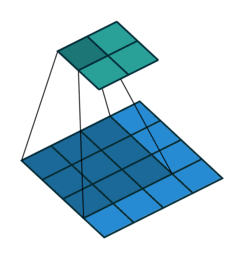
- 위의 예시에서 가중치 텐서의 형태는 $(6, 1, 5, 5)=(C_{out}, C_{in}, 커널 높이, 커널 너비)$이다.
- 또한, 가중치 텐서에 포함된 커널 행렬의 수는 총 $6*1 = 6$개이고, 스칼라는 총 $6 * 1 * 5 * 5 = 150$개이다.
- 다음 코드는 `Conv2d`의 $C_{in}$, $C_{out}$에 따른 커널(`conv.weight`)의 형태와 스칼라 원소 수를 표시한 것이다

In [63]:
def show_weight(in_channels, out_channels, kernel_size):
    conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
    print(conv.weight.shape, conv.weight.numel())
    assert(conv.weight.shape == (out_channels, in_channels, kernel_size, kernel_size))
show_weight(in_channels=1, out_channels=6, kernel_size=5)
show_weight(in_channels=1, out_channels=6, kernel_size=2)
show_weight(in_channels=1, out_channels=1, kernel_size=2)
show_weight(in_channels=1, out_channels=3, kernel_size=2)
show_weight(in_channels=3, out_channels=1, kernel_size=2)
# ...

torch.Size([6, 1, 5, 5]) 150
torch.Size([6, 1, 2, 2]) 24
torch.Size([1, 1, 2, 2]) 4
torch.Size([3, 1, 2, 2]) 12
torch.Size([1, 3, 2, 2]) 12


- 위에서 들었던 예시는 최초로 만들어진 CNN 모델인 `LeNet5`의 첫 번째 합성곱 층이다.
- INPUT 32x32는 입력된 이미지의 크기, 6@28x28은 28x28크기의 피처맵이 6장 만들어졌다는 뜻이다.
  - 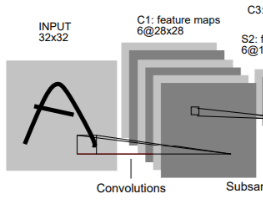

- 정사각형이 아닌 커널을 사용하고 싶다면 `kernel_size`에 정수 대신 형태를 나타내는 튜플을 넣으면 된다.

In [38]:
conv = nn.Conv2d(1, 6, kernel_size=(4, 2))
print(conv.weight.shape, conv.weight.numel())

torch.Size([6, 1, 4, 2]) 48


- `padding`과 `stride`는 커널의 행동과 출력되는 특성 맵의 크기에 영향을 미친다.
  - `padding`은 입력 이미지의 왼쪽, 오른쪽, 아래, 위 테두리에 몇 픽셀을 더 추가한다. 커널은 원래는 상호상관함수를 적용할 수 없었던 테두리 픽셀에서 상호상관함수를 적용할 수 있게 된다. 따라서 출력되는 특성 맵의 크기가 커진다.
  - `stride`는 커널이 한 번에 움직이는 거리이다. 한 번에 움직이는 거리가 클 수록, 듬성 듬성 상호상관함수를 적용한다. 따라서, 출력되는 특성 맵의 크기도 작아진다.
  - $(W, H)$가 이미지의 크기, $(P_W, P_H)$가 패딩, $(K_W, K_H)$가 커널의 형태, $S$가 스트라이드일 때, 출력되는 특성 맵의 크기는 다음 공식으로 구할 수 있다.

$$
\text{output shape} = \Bigg(
\Bigg\lceil \frac{W + 2P_w - K_w + 1}{S} \Bigg\rceil, 
\Bigg\lceil \frac{H + 2P_h - K_h + 1}{S} \Bigg\rceil
\Bigg)
$$

In [64]:
import math
def show_output_shape(kernel, stride, padding):
    image_width = 32
    image_height = 32
    input = torch.randn((1, 1, image_width, image_height))
    conv = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=kernel, stride=stride, padding=padding)
    output = conv.forward(input)
    print("output.shape :".rjust(40,' '), output.shape)
    assert((
        math.ceil((image_width + 1 + padding*2 - kernel[0])/stride),
        math.ceil((image_height + 1 + padding*2 - kernel[1])/stride)
    ) == output[0][0].shape)

show_output_shape((5,5), 1, 0) # 기본값
show_output_shape((5,5), 1, 2) # 테두리가 2칸 늘어나니 특성 맵은 더 커지겠군요
show_output_shape((5,5), 2, 1) # 1칸이 아니라 2칸 마다 한 번 씩 계산하니 특성 맵의 크기는 거의 반절이 되겠군요
show_output_shape((5,5), 3, 1)
show_output_shape((5,5), 3, 2)
show_output_shape((5,5), 5, 5)
show_output_shape((5,5), 2, 5)
# ...

                          output.shape : torch.Size([1, 6, 28, 28])
                          output.shape : torch.Size([1, 6, 32, 32])
                          output.shape : torch.Size([1, 6, 15, 15])
                          output.shape : torch.Size([1, 6, 10, 10])
                          output.shape : torch.Size([1, 6, 11, 11])
                          output.shape : torch.Size([1, 6, 8, 8])
                          output.shape : torch.Size([1, 6, 19, 19])


- 이 페이지에서 패딩과 스트라이드에 따라 합성층 연산이 다르게 이루어지는 모습을 애니메이션으로 볼 수 있다 : <https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md>
- 보통은 `Conv2d` 모듈로 이미지를 배치로 처리할 때, 배치와 배치 사이에 데이터 분포가 상이해지기 떄문에 그 출력을 곧장 `torch.nn.BatchNorm2d` 모듈로 이어 정규화 한다. <https://gaussian37.github.io/dl-concept-batchnorm/>